In [373]:
import sys ; sys.path.append("../") # osx
import cvlib

import numpy as np
import cv2 as cv

import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use(['dark_background'])

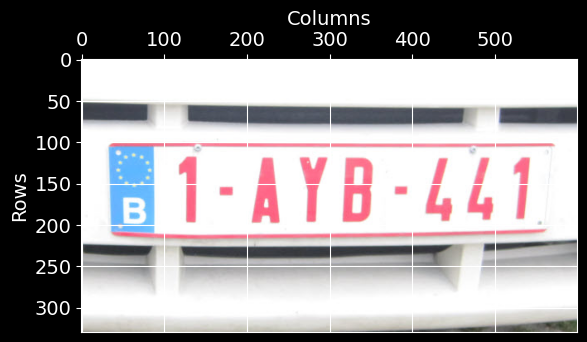

In [395]:
path = "./imagenes/"
filename = path + 'images5.jpg'
img = cv.imread(filename,cv.IMREAD_COLOR) 
img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
cvlib.imgview(img, axis=True)

In [396]:
def float64_to_uint8(img, centered=False):
    if not centered:
        img = abs(img)

    temp = 255*(img - img.min())/(img.max() - img.min())
    
    return temp.astype(np.uint8)

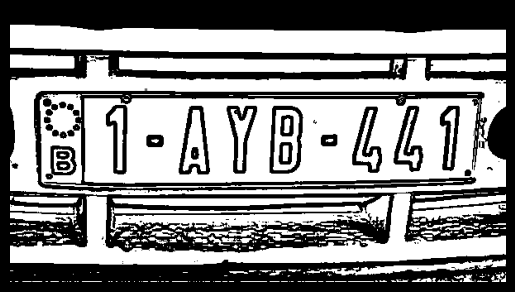

In [397]:
im = cv.imread(filename, cv.IMREAD_GRAYSCALE)
sobelx = cv.Sobel(im, cv.CV_64F, 1,0, ksize=5)
sobely = cv.Sobel(im, cv.CV_64F, 0,1, ksize=5)
sx = float64_to_uint8(sobelx)
sy = float64_to_uint8(sobely)
s = sobelx+sobely
result  =  (sx+sy)
imgbin = 255 -cv.adaptiveThreshold(result, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,127,5)
cvlib.imgview(imgbin)

In [398]:
mode = cv.RETR_TREE
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE] 
contours, hierarchy = cv.findContours(imgbin, mode, method[1])

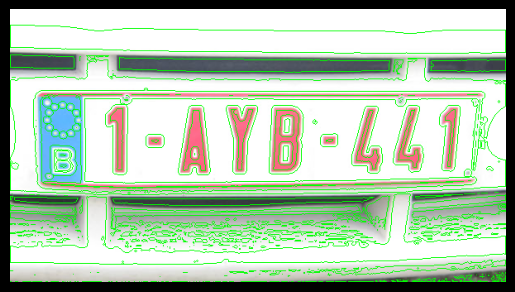

In [399]:
# draw contours over image
index = -1
color = (0,255,0) #(r,g,b)  #Esto es el color
thickness = 1               #Esto es el grosor
imgcont = cv.drawContours(img.copy(), contours, index, color, thickness)
cvlib.imgview(imgcont)

0.8080966469428008
este contorno es posible  347
0.2501846590909091
este contorno es posible  387
0.08950617283950617
este contorno es posible  416


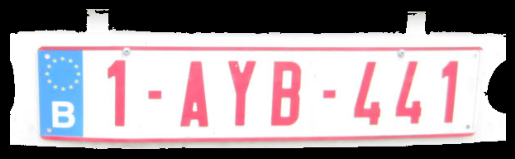

In [400]:
contornos_posibles = {}
index = -1
color = (0,255,0) 
thickness = 1              

r = img.copy()

for c in range(len(contours)): #Se recorren los contornos
    mask = np.zeros_like(img)
    cv.drawContours(mask, contours, c, (255, 255, 255), thickness=cv.FILLED)
    region_of_interest = cv.bitwise_and(r, mask)
    
    #Aqui obtengo solo el rectangulo que encierra el contorno.
    x, y, w, h = cv.boundingRect(contours[c])
    img_new = region_of_interest[y:y+h, x:x+w]

    #RGB a HSV
    #https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv?lq=1
    frameHSV = cv.cvtColor(img_new, cv.COLOR_RGB2HSV)

    #Azul
    color_rgb = np.uint8([[[73, 56, 209]]])  # [B, G, R]
    color_hsv = cv.cvtColor(color_rgb, cv.COLOR_BGR2HSV)
    rango_bajo = np.array([color_hsv[0][0][0]- 10, 100, 100], dtype=np.uint8)
    rango_alto = np.array([color_hsv[0][0][0]+ 10, 255, 255], dtype=np.uint8)
    mask_azul = cv.inRange(frameHSV,rango_bajo,rango_alto)

    #Blanco
    blancoBajo = np.array([0, 0, 200], np.uint8)
    blancoAlto = np.array([179, 50, 255], np.uint8)
    mask_blanco = cv.inRange(frameHSV,blancoBajo,blancoAlto)

    if((255 in mask_azul) and (255 in mask_blanco) ):
        aspect_ratio = float(w)/h
        if(aspect_ratio > 1.5):
            area = cv.contourArea(contours[c])
            x,y,w,h = cv.boundingRect(contours[c])
            rect_area = w*h
            extent = float(area)/rect_area
            print(extent)
            print("este contorno es posible ", c)
            if(extent > 0.8):
                if(len(contornos_posibles.keys()) > 0):
                    if(contornos_posibles.keys()[0] < extent):
                        contornos_posibles.clear()
                        contornos_posibles[extent] = [img_new, (x,y,w,h)]
                else:
                    contornos_posibles[extent] = [img_new, (x,y,w,h)]
            #Ya que se tiene extent hay que filtrar los contronos que estén arriba de 0.8
            #Si hay más de un contorno que esté por encima de 0.8, entonces hay que seleccionar el contorno que tenga en extent más alto. 
# x1,y1,w1,h1  = list(contornos_posibles.values())[0]
cvlib.imgview(list(contornos_posibles.values())[0][0])
    

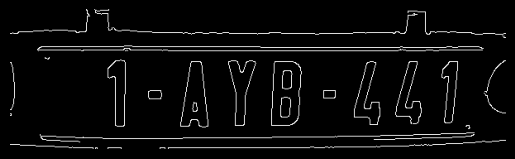

In [401]:
gray = cv.cvtColor(list(contornos_posibles.values())[0][0],cv.COLOR_BGR2GRAY)
gray =  cv.GaussianBlur(gray,(3,3),0)
canny = cv.Canny(gray, 150, 200, apertureSize=3)
cvlib.imgview(canny)

In [402]:
x1,y1,w1,h1  = list(contornos_posibles.values())[0][1]
# cvlib.imgview(cv.rectangle(img, (x1, y1), (x1+w1, y1+h1), (0, 255, 0), 2))

In [403]:
mode = cv.RETR_TREE
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE] 
contours, hierarchy = cv.findContours(canny, mode, method[1])

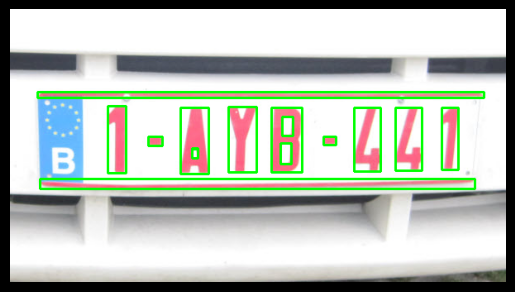

In [404]:
# Dibuja los rectángulos en la imagen original
r = list(contornos_posibles.values())[0][0].copy()
for c in range(len(contours)):

   mask = np.zeros_like(list(contornos_posibles.values())[0][0])
   cv.drawContours(mask, contours, c, (255, 255, 255), thickness=cv.FILLED)
   region_of_interest = cv.bitwise_and(r, mask)
   
   #Aqui obtengo solo el rectangulo que encierra el contorno.
   x, y, w, h = cv.boundingRect(contours[c])
   img_new = region_of_interest[y:y+h, x:x+w]
   
   frameHSV = cv.cvtColor(img_new, cv.COLOR_RGB2HSV)

   #Azul
   color_rgb = np.uint8([[[73, 56, 209]]])  # [B, G, R]
   color_hsv = cv.cvtColor(color_rgb, cv.COLOR_BGR2HSV)
   rango_bajo = np.array([color_hsv[0][0][0]- 10, 100, 100], dtype=np.uint8)
   rango_alto = np.array([color_hsv[0][0][0]+ 10, 255, 255], dtype=np.uint8)
   mask_azul = cv.inRange(frameHSV,rango_bajo,rango_alto)

   if (255 in mask_azul):
      x, y, w, h = cv.boundingRect(contours[c])
      cv.rectangle(img, (x1 +x,  y1 + y), (x1 +x+w, y1 +y+h), (0, 255, 0), 2)  # Cambia el color y grosor según tus preferencias
   
cvlib.imgview(img)

# Pruebas

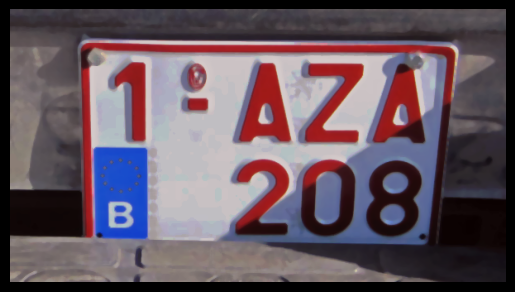

In [327]:
eq = imgeq(img)
# Aplica un filtro de mediana para suavizar la imagen
imagen_suavizada = cv.medianBlur(eq, 5)

# Ajusta el contraste
alpha = 0.8
 # Puedes ajustar este valor según tus necesidades
imagen_contraste = cv.convertScaleAbs(imagen_suavizada, alpha=alpha)

# Ajusta el brillo
beta = 10  # Puedes ajustar este valor según tus necesidades
imagen_brillante = cv.add(imagen_contraste, beta)

cvlib.imgview(imagen_brillante)

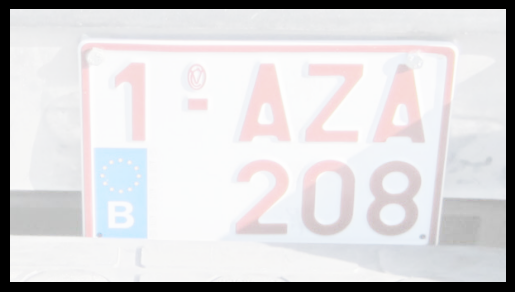

In [342]:
# Convertir la imagen a punto flotante
imagen_float = img.astype(float) / 255.0

# Definir el valor gamma (ajusta según tus necesidades)
gamma = 0.09

# Aplicar la corrección de gamma
imagen_corregida = np.power(imagen_float, gamma)

# Asegurarse de que los valores estén en el rango [0, 1]
imagen_corregida = np.clip(imagen_corregida, 0, 1)

# Convertir la imagen de nuevo a valores enteros en el rango [0, 255]
imagen_corregida = (imagen_corregida * 255).astype(np.uint8)

cvlib.imgview(imagen_corregida)

este contorno es posible  12


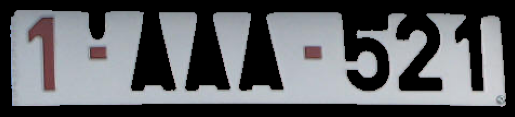

este contorno es posible  16


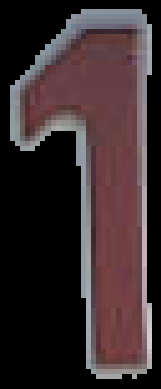

In [83]:
mode = cv.RETR_TREE
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE] 
contours, hierarchy = cv.findContours(edges, mode, method[1])

index = -1
color = (0,255,0) 
thickness = 1              

r = img.copy()

for c in range(len(contours)): #Se recorren los contornos
    mask = np.zeros_like(img)
    cv.drawContours(mask, contours, c, (255, 255, 255), thickness=cv.FILLED)
    region_of_interest = cv.bitwise_and(r, mask)

    #Aqui obtengo solo el rectangulo que encierra el contorno.
    x, y, w, h = cv.boundingRect(contours[c])
    img_new = region_of_interest[y:y+h, x:x+w]

    #RGB a HSV
    #https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv?lq=1
    frameHSV = cv.cvtColor(img_new, cv.COLOR_RGB2HSV)

    #Azul
    color_rgb = np.uint8([[[73, 56, 209]]])  # [B, G, R]
    color_hsv = cv.cvtColor(color_rgb, cv.COLOR_BGR2HSV)
    rango_bajo = np.array([color_hsv[0][0][0]- 10, 100, 100], dtype=np.uint8)
    rango_alto = np.array([color_hsv[0][0][0]+ 10, 255, 255], dtype=np.uint8)
    mask_azul = cv.inRange(frameHSV,rango_bajo,rango_alto)

    #Blanco
    blancoBajo = np.array([0, 0, 200], np.uint8)
    blancoAlto = np.array([255, 255, 255], np.uint8)
    mask_blanco = cv.inRange(frameHSV,blancoBajo,blancoAlto)

    #Negro
    color_rgb_negro = np.uint8([[[0, 0, 0]]])  # [B, G, R]
    color_hsv_negro = cv.cvtColor(color_rgb_negro, cv.COLOR_BGR2HSV)
    negroBajo = np.array([0, 0, 0], dtype=np.uint8)
    negroAlto = np.array([179, 255, 30], dtype=np.uint8)
    mask_negro = cv.inRange(frameHSV,negroBajo,negroAlto)

    if((255 in mask_azul) and (255 in mask_blanco) and (255 in mask_negro)):
        print("este contorno es posible ", c)
        cvlib.imgview(img_new)
    

## Prueba funciona con 1

In [24]:
mode = cv.RETR_TREE
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE] 
contours, hierarchy = cv.findContours(canny, mode, method[1])

index = -1
color = (0,255,0) 
thickness = 1              

r = img.copy()



mask = np.zeros_like(img.copy())
cv.drawContours(mask, contours, 76, (255, 255, 255), thickness=cv.FILLED)
region_of_interest = cv.bitwise_and(img.copy(), mask)

#Aqui obtengo solo el rectangulo que encierra el contorno.
x, y, w, h = cv.boundingRect(contours[76])
img_new = region_of_interest[y:y+h, x:x+w]

#RGB a HSV
#https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv?lq=1
frameHSV = cv.cvtColor(img_new, cv.COLOR_RGB2HSV)

#Azul
azulBajo = np.array([91, 100, 20], np.uint8)
azulAlto = np.array([145, 255, 255], np.uint8)
mask_azul = cv.inRange(frameHSV,azulBajo,azulAlto)

#Blanco
blancoBajo = np.array([0, 0, 200], np.uint8)
blancoAlto = np.array([255, 255, 255], np.uint8)
mask_blanco = cv.inRange(r,blancoBajo,blancoAlto)

if((255 in mask_azul) and (255 in mask_blanco)):
    print("este contorno es posible")


este contorno es posible


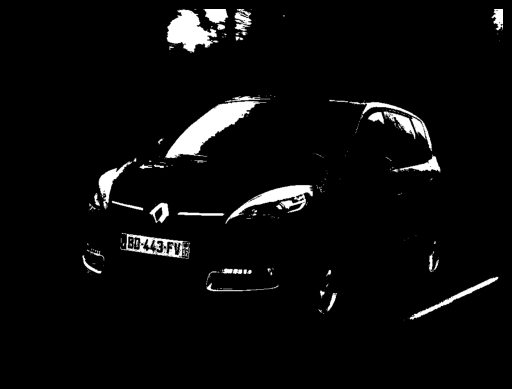

In [25]:
cvlib.imgview(mask_blanco)

## Pruebas

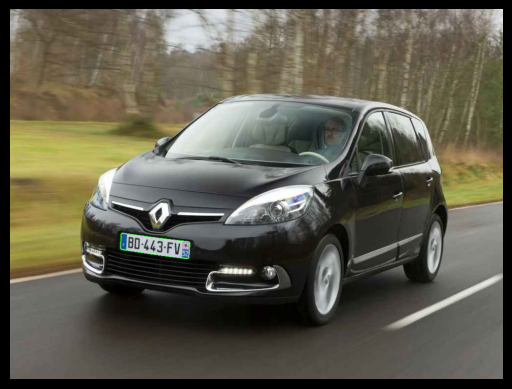

In [5]:
# compute contours
mode = cv.RETR_TREE # contour retrieval mode
method = [cv.CHAIN_APPROX_NONE, cv.CHAIN_APPROX_SIMPLE] # contour approximation method 
contours, hierarchy = cv.findContours(canny, mode, method[1])

index = -1
color = (0,255,0) #(r,g,b)  #Esto es el color
thickness = 1               #Esto es el grosor

# r = img.copy() #Se realiza una copia de la imagen original
# for c in range(76,80): #Se recorren los contornos
#     r = cv.drawContours(r, contours, c, color, thickness)

imgcont = cv.drawContours(img.copy(), contours, 76, color, thickness)

cvlib.imgview(imgcont)

TypeError: Invalid shape (5, 1, 2) for image data

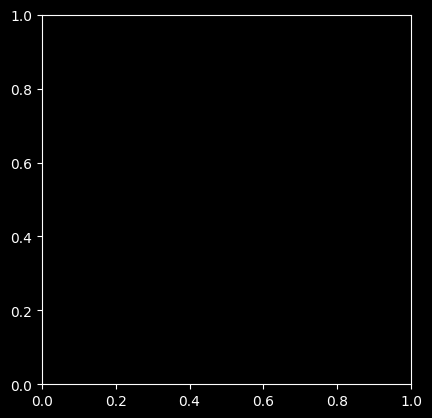

In [9]:
hull = cv.convexHull(contours[82])
imgcont = cv.drawContours(img.copy(), [hull], -1, color, thickness)
cvlib.imgview(hull)

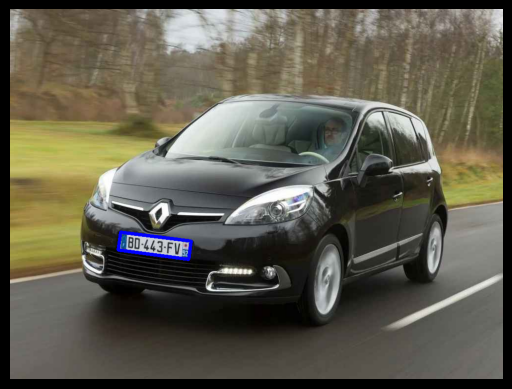

In [6]:
rect = cv.minAreaRect(contours[76])
box = cv.boxPoints(rect)
box = np.int0(box)
cvlib.imgview(cv.drawContours(img.copy(),[box],0,(0,0,255),5))

In [7]:
leftmost = tuple(contours[76][contours[76][:,:,0].argmin()][0])
rightmost = tuple(contours[76][contours[76][:,:,0].argmax()][0])
topmost = tuple(contours[76][contours[76][:,:,1].argmin()][0])
bottommost = tuple(contours[76][contours[76][:,:,1].argmax()][0])
[leftmost,rightmost,topmost,bottommost]

[(223, 485), (365, 473), (227, 453), (361, 506)]

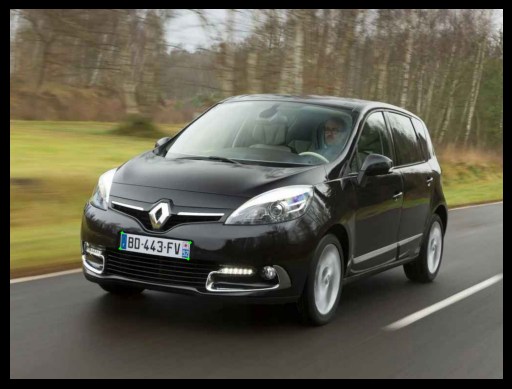

In [8]:
r = img.copy()
for p in [leftmost,rightmost,topmost,bottommost]:
    r = cv.circle(r, p, radius=1, color=(0, 255, 0), thickness=4)
cvlib.imgview(r)